# Annotate phylogeny of Californian SARS-CoV-2 sequences with mobility data

This notebook is a proof of concept for how one might annotate phylogenies inferred from SARS-CoV-2 genomes with mobility data to better understand how changes in mobility are related to viral transmission.

## Setup

Import modules and define utility functions.

In [1]:
from augur.utils import json_to_tree
import datetime
import json
import pandas as pd
import requests

In [2]:
# Convert numerical dates to ISO dates.
def float_to_datestring(time):
    """Convert a floating point date from TreeTime `numeric_date` to a date string
    """
    # Extract the year and remainder from the floating point date.
    year = int(time)
    remainder = time - year

    # Calculate the day of the year (out of 365 + 0.25 for leap years).
    tm_yday = int(remainder * 365.25)
    if tm_yday == 0:
        tm_yday = 1

    # Construct a date object from the year and day of the year.
    date = datetime.datetime.strptime("%s-%s" % (year, tm_yday), "%Y-%j")

    # Build the date string with zero-padded months and days.
    date_string = "%s-%.2i-%.2i" % (date.year, date.month, date.day)

    return date_string

## Prepare mobility data

Download the Google Mobility data.

In [5]:
mobility_data_url = "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=204bd65a761b3b2a"
df = pd.read_csv(mobility_data_url)

/Users/jlhudd/miniconda3/envs/mobility/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Extract rows for California.

In [6]:
california_df = df.query("country_region_code == 'US' & sub_region_1 == 'California'").copy()

Extract rows with county-level data.

In [7]:
county_level_df = california_df[~pd.isnull(california_df["sub_region_2"])].copy()

Select a subset of relevant columns. In this notebook, we only use the change from baseline mobility for retail and recreation as an example.

In [8]:
county_level_df = county_level_df.loc[:, ["sub_region_2", "date", "retail_and_recreation_percent_change_from_baseline"]].copy()

Rename mobility column name for county to a more interpretable name.

In [9]:
county_level_df["county"] = county_level_df["sub_region_2"].str.replace(" County", "")

## Prepare phylogenetic data

Download the latest California tree from covidtracker.

In [10]:
tree_url = "https://github.com/czbiohub/covidtracker/raw/master/auspice/covidtracker_ca.json"
response = requests.get(tree_url)

Load the tree.

In [11]:
tree_json = json.loads(response.content)
tree = json_to_tree(tree_json)

Extract strain name, date, and county for each tip.

In [12]:
attrs = [
    "county",
    "num_date"
]

In [13]:
tree_records = []
for tip in tree.find_clades(terminal=True):
    record = {"strain": tip.name}
    for attr in attrs:
        if attr in tip.node_attrs:
            record[attr] = tip.node_attrs[attr]["value"]
        else:
            record[attr] = "N/A"

    tree_records.append(record)

In [14]:
tree_df = pd.DataFrame(tree_records)

Convert numerical dates to ISO dates.

In [15]:
tree_df["date"] = tree_df["num_date"].apply(float_to_datestring)

## Annotate phylogenetic data with mobility data

Annotate strain metadata with mobility data for the corresponding date and county. Drop records where we don't have any mobility information. Keep only a subset of the final columns.

In [16]:
tree_with_mobility_df = tree_df.merge(
    county_level_df,
    on=["date", "county"],
    how="left"
).dropna().loc[:, ["strain", "date", "retail_and_recreation_percent_change_from_baseline"]].copy()

Bin mobility data into quartiles for categorical view in Nextstrain. We have limited control over how colors appear for drag-and-drop metadata. For production use, we might prefer to color by the continuous mobility values and let Nextstrain provide an appropriate color ramp.

Lower binned values correspond to reduced mobility.

In [17]:
tree_with_mobility_df["binned_mobility"] = pd.qcut(
    tree_with_mobility_df["retail_and_recreation_percent_change_from_baseline"],
    4,
    labels=["0-25%", "25-50%", "50-75%", "75-100%"]
)

## Export annotated phylogenetic data for visualization in Nextstrain

Save the annotated strain data to a CSV that we can drag-and-drop onto the tree in Nextstrain.

In [18]:
tree_with_mobility_df.to_csv(
    "california_mobility.csv",
    header=True,
    index=False
)

Drag and drop the resulting CSV file onto the [CZB California build in Nextstrain](https://nextstrain.org/community/czbiohub/covidtracker/ca).

[Change the "Color By" option to "binned_mobility"](https://nextstrain.org/community/czbiohub/covidtracker/ca?c=binned_mobility&m=num_date&p=grid), to see how mobility maps onto the phylogeny.

Below is an example view showing differential mobility in the Bay Area over the entire course of the pandemic for clade 20C.
Lower binned values correspond to reduced mobility.

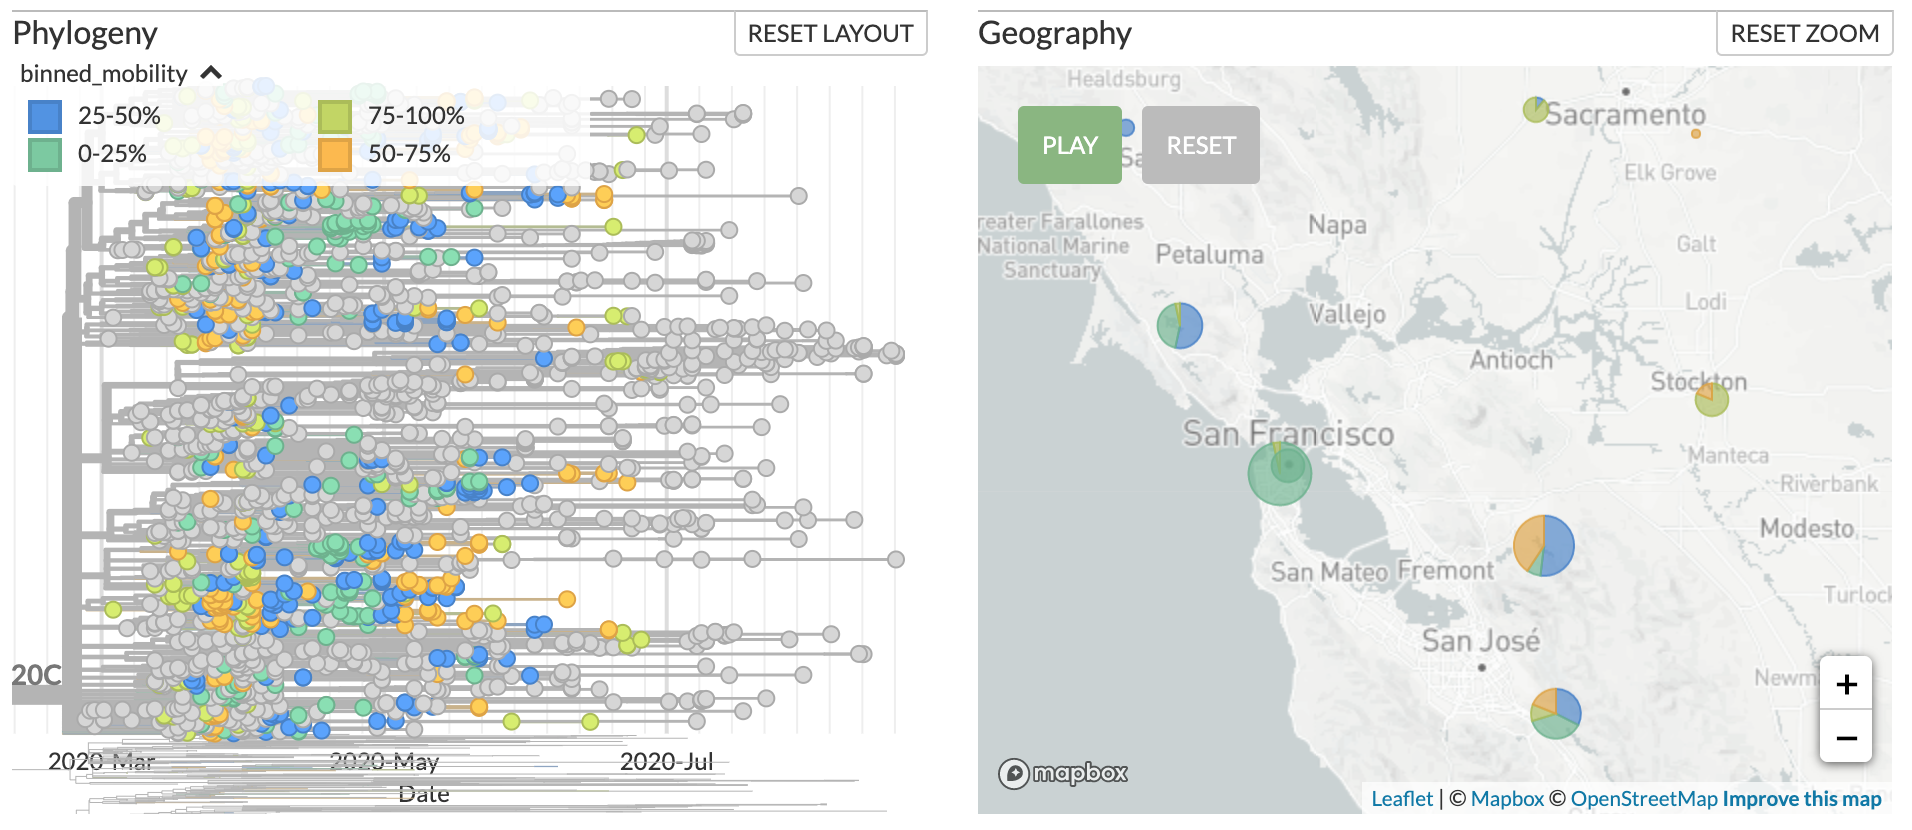

## Potential next steps

 - Use mobility data from all available states and counties in the US
 - Use all mobility fields either as separate color-by options or as inputs to a model that outputs a general mobility score per county and date
 - Inspect the relationship between continuous mobility values per strain and number of descendant strains of each strain's immediate ancestral node
 - Investigate known transmission networks in the tree from the context of changes in county mobility
 